# Hand motions classification using non-invasive EEG recordings
### by Cedric Simar and Antoine Passemiers
<hr/>

## Table of content

* [0 - Introduction](#introduction)
  * [0.1. Problem description](#problem-description)


* [1 - Preprocessing](#preprocessing)
  * [1.1. Import useful libraries](#import-libraries)
  * [1.2. Load the data](#load-data)
  * [1.3. Band-pass filtering](#band-pass-filtering)
  * [1.4. Downsampling](#downsampling)
  * [1.5. Extract covariance matrices](#extract-cov)


* [2. Riemannian-based kernel trick](#kernel-trick)


* [3. Models](#models)
  * [3.1. Linear Discriminant Analysis](#lda)


* [4. Bibliography](#bibliography)

## Introduction <a class="anchor" id="introduction"></a>
<hr/>

### Problem description <a class="anchor" id="problem-description"></a>

In [1]:
from IPython.display import HTML
url = "https://www.youtube.com/embed/y3_Izuop2gY?rel=0&amp;controls=0&amp;showinfo=0"
HTML('<iframe style="display:block" width="560" height="315" src="%s" frameborder="0" allowfullscreen></iframe>' % url)

## Preprocessing <a class="anchor" id="preprocessing"></a>
<hr/>

### Import useful libraries <a class="anchor" id="import-libraries"></a>

In [1]:
%load_ext Cython

import cython
import os
import gc
import time
import scipy.linalg
import scipy.signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Load the data <a class="anchor" id="load-data"></a>

TODO Cedric: descriptions (electrodes, multi-labels, échantillonage, tout ça tout ça)

<figure style="text-align:center;">
  <img src="imgs/EEG_Electrode_Numbering.jpg" style="width:450px;">
  <figcaption> Source: [Kaggle](#bib-kaggle) </figcaption>
</figure>

In [2]:
N_PATIENTS = 12
# Feature names
ELECTRODE_NAMES = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
# Label names
EVENT_NAMES = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']


def load_dataset(subject=-1, data_dir='', with_test_data=True):
    """
    Parameters
    ----------
    subject: int, list, np.ndarray
        Either a subject id or a sequence of ids. If subject is set to -1,
        the data from all patients will be returned
    data_dir: str
        path to the folder where train/ and test/ subfolders are located
    with_test_data: bool
        If set to true, test series/set will be returned
    
    Return
    ------
    If with_test_data: List of couples of dataframes
    Otherwise: List of dataframes
    """
    if type(subject) == int:
        subject_ids = list(range(1, N_PATIENTS+1)) if subject == -1 else [subject]
    else:
        subject_ids = list(subject)
    print("Loading dataset...")
    subjects_data = list()
    for subject_id in subject_ids:
        subject_train_data = list()
        for series_id in range(1, 9):
            print("\tSeries %i of subject %i" % (series_id, subject_id))
            train_data_filename = os.path.join(
                data_dir, 'train/subj%s_series%s_data.csv' % (subject_id, series_id))
            events_filename = os.path.join(
                data_dir, 'train/subj%s_series%s_events.csv' % (subject_id, series_id))
            train_series, events = pd.read_csv(train_data_filename), pd.read_csv(events_filename)
            train_series[EVENT_NAMES] = events[EVENT_NAMES]
            subject_train_data.append(train_series)
        if with_test_data:
            subject_test_data = list()
            for series_id in range(9, 11):
                test_data_filename = os.path.join(
                    data_dir, 'test/subj%s_series%s_data.csv' % (subject_id, series_id))
                subject_test_data.append(pd.read_csv(test_data_filename))
            subjects_data.append((subject_train_data, subject_test_data))
        else:
            subjects_data.append(subject_train_data)
    return subjects_data

In [46]:
 # Take first list element since we consider only patient number 1
training_set = load_dataset(subject=1, data_dir='data', with_test_data=False)[0]

training_set = pd.concat(training_set)

X_train = np.asarray(training_set[ELECTRODE_NAMES], dtype=np.int16)
Y_train = np.asarray(training_set[EVENT_NAMES], dtype=np.int16)

Loading dataset...
	Series 1 of subject 1
	Series 2 of subject 1
	Series 3 of subject 1
	Series 4 of subject 1
	Series 5 of subject 1
	Series 6 of subject 1
	Series 7 of subject 1
	Series 8 of subject 1


### Band-pass filtering <a class="anchor" id="band-pass-filtering"></a>

To avoid creating potential aliasing effects, we apply necessary spectral filters on the raw signals before to downsample them.

In [47]:
class BandPassFilter:
    
    def __init__(self, lowcut_freq, highcut_freq, sampling_freq, order=3):
        self.nyquist_freq = sampling_freq / 2.
        lower_bound = lowcut_freq / self.nyquist_freq
        upper_bound = highcut_freq / self.nyquist_freq
        self.b, self.a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='band')
    
    def lfilter(self, signal):
        # TODO: does lfiter include future data when filtering current frame? 
        return scipy.signal.lfilter(self.b, self.a, signal, axis=0)

In [48]:
# Sampling frequency: 500 Hz (from the dataset description)
# Filter band of interest (from Barachant et al.): 8 Hz to 35 Hz (µ and β frequency bands)
bandpass = BandPassFilter(8, 35, 500)

X_train_filtered = bandpass.lfilter(X_train)

### Downsampling <a class="anchor" id="downsampling"></a>

In [31]:
# 500 Hz -> 125 Hz
X_train_filtered_125Hz, Y_train_125Hz = X_train_filtered[::4], Y_train[::4]

### Extract covariance matrices <a class="anchor" id="extract-cov"></a>

In [12]:
%%cython

import numpy as np
cimport numpy as cnp
cnp.import_array()
import cython

@cython.boundscheck(False)
@cython.overflowcheck(False)
def extract_cov_matrices(cnp.float_t[:, :] data, Py_ssize_t w):
    cdef Py_ssize_t n_features = data.shape[1]
    cdef cnp.float_t[:, :, :] sigmas = np.empty((data.shape[0], n_features, n_features), dtype=np.float)
    cdef cnp.float_t[:] means = np.asarray(np.mean(np.asarray(data)[:w, :], axis=0), dtype=np.float)
    cdef cnp.float_t[:] old_means = np.copy(means)
    cdef cnp.float_t[:, :] last_sigma = np.cov(np.asarray(data)[:w, :].T)
    cdef cnp.float_t c
    np_sigmas = np.asarray(sigmas)
    np_sigmas[:w, :, :] = np.repeat(np.asarray(last_sigma).reshape((1, n_features, n_features), order='C'), w, axis=0)
    cdef Py_ssize_t i, j, a, b
    with nogil:
        for i in range(w, data.shape[0]):
            for a in range(n_features):
                old_means[a] = means[a]
                means[a] += (data[i, a] - data[i-w, a]) / w
            for a in range(n_features):
                for b in range(a+1):
                    c = sigmas[i-1, a, b]
                    c += (data[i, a] * data[i, b] - data[i-w, a] * data[i-w, b]) / w
                    c += old_means[a] * old_means[b] - means[a] * means[b]
                    sigmas[i, a, b] = sigmas[i, b, a] = c
    return np_sigmas

In [39]:
X_train_cov = extract_cov_matrices(X_train_filtered_125Hz[:100000].astype(np.float), 900)
Y_train_125Hz_sub = Y_train_125Hz[:100000]

X_train_cov = X_train_cov[::20]
Y_train_125Hz_sub = Y_train_125Hz_sub[::20]

print(X_train_cov.shape, Y_train_125Hz_sub.shape)

(5000, 32, 32) (5000, 6)


## Riemannian-based kernel trick <a class="anchor" id="kernel-trick"></a>

In [40]:
def hlmap(Cp, sqrtCinv):
    return scipy.linalg.logm(sqrtCinv * Cp * sqrtCinv)

def hemap(Cp, sqrtC):
    return scipy.linalg.expm(sqrtC * Cp * sqrtC)

print("This step might take a couple a minutes...")
sqrtC = scipy.linalg.sqrtm(X_train_cov[0])
sqrtCinv = scipy.linalg.inv(sqrtC)
X_train_cov = np.asarray([hlmap(h, sqrtCinv) for h in X_train_cov])

This step might take a couple a minutes...


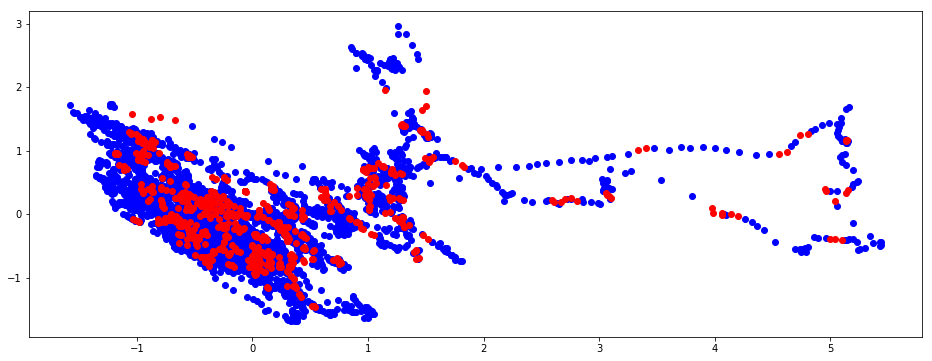

In [45]:
pca = PCA(n_components=2)
points = pca.fit_transform(X_train_cov.reshape(len(X_train_cov), -1))

labels = Y_train_125Hz_sub
nothing = labels.sum(axis=1) == 0
something = labels.sum(axis=1) > 0

plt.figure(figsize=(16, 6))
plt.scatter(points[nothing, 0], points[nothing, 1], c='blue')
plt.scatter(points[something, 0], points[something, 1], c='red')
plt.show()

## Models <a class="anchor" id="models"></a>
<hr/>

### Linear discriminant analysis <a class="anchor" id="lda"></a>

In [54]:
from sklearn.lda import LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef

_X_train = X_train_cov[:4000]
_X_train = _X_train.reshape(_X_train.shape[0], -1)
_Y_train = Y_train_125Hz_sub[:4000]

_X_val = X_train_cov[4000:]
_X_val = _X_val.reshape(_X_val.shape[0], -1)
_Y_val = Y_train_125Hz_sub[4000:]

for i in range(6):
    clf = RandomForestClassifier()
    clf.fit(_X_train, _Y_train[:, i])
    print(matthews_corrcoef(_Y_train[:, i], clf.predict(_X_train)))
    print(matthews_corrcoef(_Y_val[:, i], clf.predict(_X_val)))
    print(clf.predict(_X_val).sum(), "\n")

0.900780012746
-0.016583181619
14 

0.937486558417
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.911438361031
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.898028993096
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.936323280257
-0.00623005705527
2 

0.914785626379
-0.0124977391004
8 



## Bibliography <a class="anchor" id="bibliography"></a>
<hr/>

* <span class="anchor" id="bib-riemann">
    [1] Classification of covariance matrices using a Riemannian-based kernel for BCI applications <br>
    Alexandre Barachant, Stéphane Bonnet, Marco Congedo, Christian Jutten <br>
    https://hal.archives-ouvertes.fr/file/index/docid/820475/filename/BARACHANT_Neurocomputing_ForHal.pdf <br>
  </span>
<br>

* <span class="anchor" id="bib-kaggle">
    [2] Grasp-and-Lift EEG Detection Kaggle Competition <br>
    https://www.kaggle.com/c/grasp-and-lift-eeg-detection <br>
  </span>
<br>